# Data Science Challenge

## Input data for task 2
You should have received 1 excel file. 

* File *manufacturing.xlsx* contains the data describing process parameters/conditions for the produced batches together with characteristics of the final product (see business case and process description below). 
    * The csv file contains the following fields:
        - **Start date** Fecha de inicio
        - **Variety Code** Código de variedad
        - **Origin** Origen
        - **Discoloration fraction** Fracción de decoloración
        - **Days since harvest** Días desde la cosecha
        - **Sugar content** Contenido de azúcar
        - **Tank temperature** Temperatura del tanque
        - **Time in tank (seconds)** Tiempo en tanque (segundos)
        - **Percentage anti-foam in water** Porcentaje de antiespumante en agua
        - **Time since last water change (minutes)** Tiempo desde el último cambio de agua (minutos)
        - **Fat temperature** temperatura de la grasa
        - **Time in oven (seconds)** Tiempo en horno (segundos)
        - **Polar fraction of fat** Fracción polar de grasa
        - **FFA in fat** FFA en grasa
        - **Average temperature after oven** Temperatura media después del horno.
        - **Scraper speed** Velocidad del raspador
        - **Color after oven** Color después del horno
        - **Color after oven (numeric)** Color después del horno (numérico)
        - **Waste after oven** Residuos/desperdicio después del horno
        - **Ambient Temperature** Temperatura ambiente
        - **Humidity** Humedad

        

All questions in this task are related to this data.

## Task 2: Production Optimization
The goal of this task is to solve business case involving the development of the analytical model using the provided data.

**Business case:**
The company manufactures packaged baked potato and aims to produce the product with *optimal* color, while keeping the raw materials waste at *minimum*. See production diagram attached.
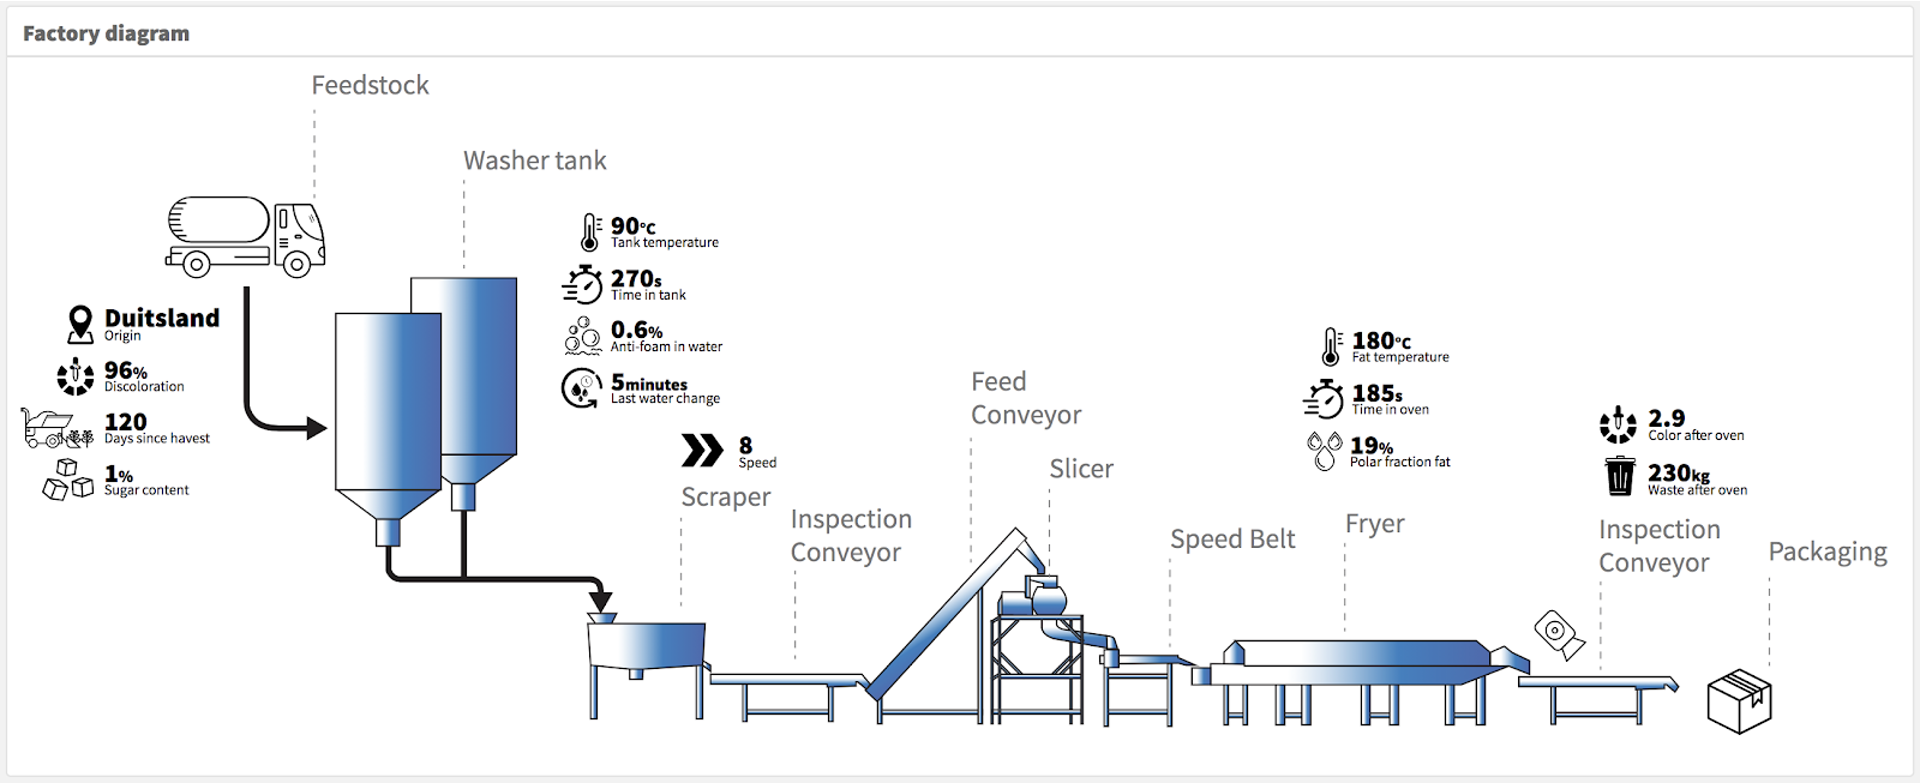



Your task as a data scientist, is to solve this problem using linear regression/regularization techniques and report your findings on how to improve the product color and reduce the waste to the *Head of production*".

Report your findings and code for the solution to us.


## Exploratory data analysis

### Loading the data

As usual, the first step is to load the data and do a preliminary exploratory data analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial


def find_correlation(df, thresh=0.9):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove
    params:
    - df : pd.DataFrame
    - thresh : correlation threshold, will remove one of pairs of features with
               a correlation greater than this value
    """
    
    corrMatrix = df.corr()
    corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1)

    already_in = set()
    result = []

    for col in corrMatrix:
        perfect_corr = corrMatrix[col][corrMatrix[col] > thresh].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)


    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat



In [2]:
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

In [3]:
# Reading the excel file into a dataframe

data = pd.read_excel("data/manufacturing.xlsx", parse_dates=["Start date"], index_col=False)

# data
# print(data)

data.shape


df=data

In [4]:
df.columns

# df

Index(['Start date', 'Variety Code', 'Origin', 'Discoloration fraction',
       'Days since harvest', 'Sugar content', 'Tank temperature',
       'Time in tank (seconds)', 'Percentage anti-foam in water',
       'Time since last water change (minutes)', 'Fat temperature',
       'Time in oven (seconds)', 'Polar fraction of fat', 'FFA in fat',
       'Average temperature after oven', 'Scraper speed', 'Color after oven',
       'Color after oven (numeric)', 'Waste after oven', 'Ambient Temperature',
       'Humidity'],
      dtype='object')

In [5]:
np.isnan(df['Waste after oven']).sum()




0

Observamos que no hay valores faltantes para `Waste after oven`. Por lo tanto procedemos a analizar el dataset.


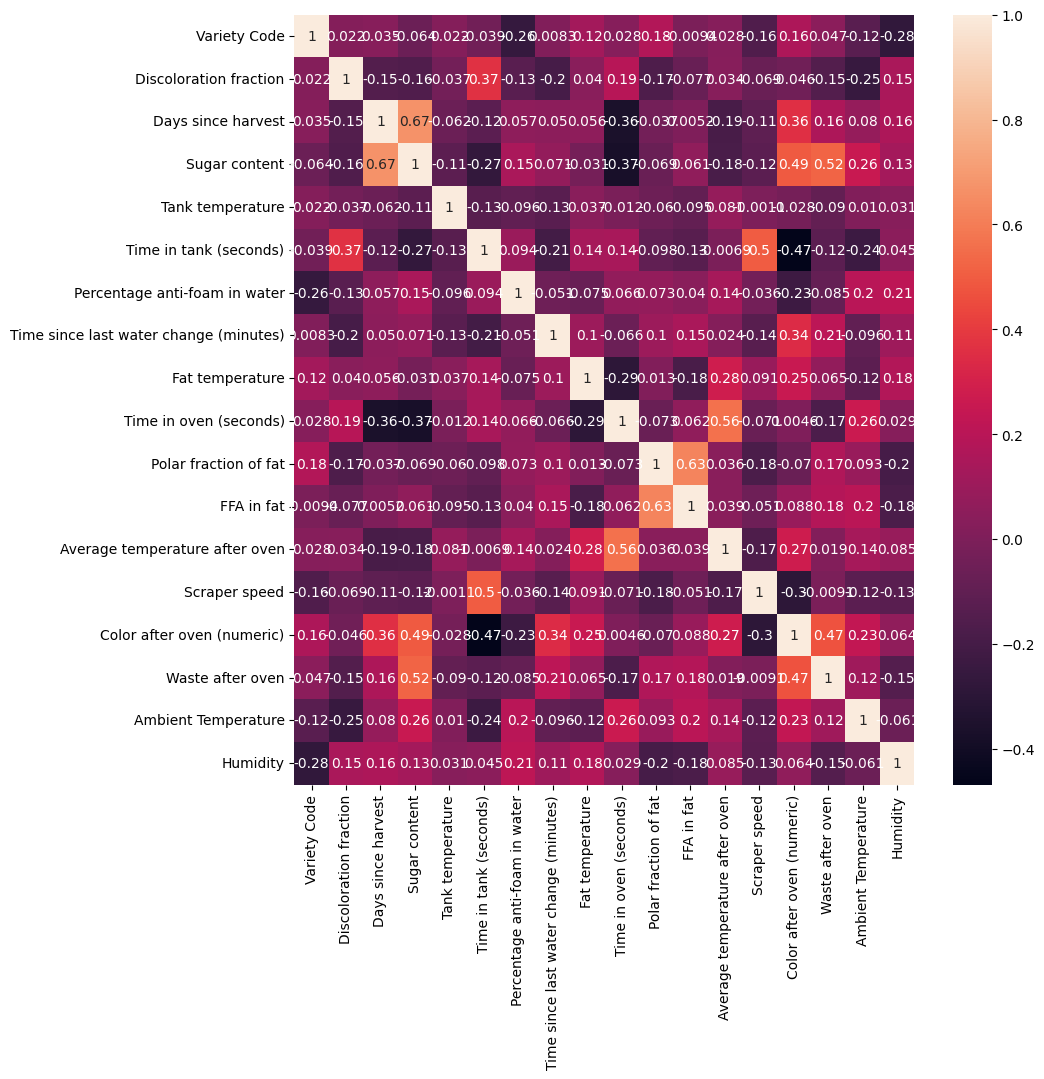

In [6]:

dataWOorigin= df.columns.drop(['Origin','Color after oven','Start date'])



# data[dataWOorigin]
df[dataWOorigin].corr(numeric_only=True)
plt.figure(figsize = (10, 10))
sns.heatmap(df[dataWOorigin].corr(numeric_only=True), annot = True)

data2=df[dataWOorigin]

In [7]:
correlated=find_correlation(df[dataWOorigin].corr(numeric_only=True),0.80)
correlated

['Days since harvest', 'Polar fraction of fat']

In [8]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 


In [9]:
design = MS(data2.columns.drop('Waste after oven')).fit(data2)
Y = np.array(data2['Waste after oven'])
X = design.transform(data2)
sigma2 = OLS(Y,X).fit().scale

In [10]:

neg_Cp = partial(nCp, sigma2)

In [11]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [12]:
df_MSE = sklearn_selected(OLS,
                               strategy)
df_MSE.fit(data2, Y)
df_MSE.selected_state_


('Ambient Temperature',
 'Average temperature after oven',
 'Color after oven (numeric)',
 'Days since harvest',
 'Discoloration fraction',
 'FFA in fat',
 'Fat temperature',
 'Humidity',
 'Percentage anti-foam in water',
 'Polar fraction of fat',
 'Scraper speed',
 'Sugar content',
 'Tank temperature',
 'Time in oven (seconds)',
 'Time in tank (seconds)',
 'Time since last water change (minutes)',
 'Variety Code')

In [13]:
df_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
df_Cp.fit(data2, Y)
df_Cp.selected_state_

('Color after oven (numeric)',
 'Days since harvest',
 'Polar fraction of fat',
 'Sugar content',
 'Time in tank (seconds)')

Recordando que correlacion es una medida estadistica de la relacion entre dos o mas variables. 

In [14]:
df.dtypes

Start date                                datetime64[ns]
Variety Code                                       int64
Origin                                            object
Discoloration fraction                           float64
Days since harvest                                 int64
Sugar content                                    float64
Tank temperature                                   int64
Time in tank (seconds)                             int64
Percentage anti-foam in water                    float64
Time since last water change (minutes)             int64
Fat temperature                                    int64
Time in oven (seconds)                             int64
Polar fraction of fat                            float64
FFA in fat                                       float64
Average temperature after oven                     int64
Scraper speed                                      int64
Color after oven                                  object
Color after oven (numeric)     

In [15]:
df_Con_Cp=df[['Color after oven (numeric)',
 'Days since harvest',
 'Polar fraction of fat',
 'Sugar content',
 'Time in tank (seconds)','Waste after oven']]
df_Con_Cp

,Color after oven (numeric),Days since harvest,Polar fraction of fat,Sugar content,Time in tank (seconds),Waste after oven
0,3,150,18.0,0.5,190,160
1,4,152,17.0,0.7,190,290
2,3,50,17.0,0.6,200,180
3,4,50,20.0,0.8,250,320
4,3,55,19.0,0.9,230,250
5,3,300,22.0,1.5,240,200
6,4,300,22.0,1.4,240,350
7,3,150,23.0,1.0,190,275
8,3,20,24.0,0.4,200,190
9,5,100,18.0,0.8,150,400


In [16]:

X=df.drop(['Waste after oven','Start date','Origin','Color after oven'],axis=1)
X.shape

y=df['Waste after oven']
y.shape

(50,)

In [17]:

X.dtypes
# X

Variety Code                                int64
Discoloration fraction                    float64
Days since harvest                          int64
Sugar content                             float64
Tank temperature                            int64
Time in tank (seconds)                      int64
Percentage anti-foam in water             float64
Time since last water change (minutes)      int64
Fat temperature                             int64
Time in oven (seconds)                      int64
Polar fraction of fat                     float64
FFA in fat                                float64
Average temperature after oven              int64
Scraper speed                               int64
Color after oven (numeric)                  int64
Ambient Temperature                         int64
Humidity                                    int64
dtype: object

In [18]:
X_train,X_test,y_train,y_test = skm.train_test_split(X,y,
                                                 test_size = 0.25,
                                                random_state = 100)

#random_state” is a parameter in train_test_split that controls the random number generator used to shuffle the data before splitting it. 
# In other words, it ensures that the same randomization is used each time you run the code, resulting in the same splits of the data.

X_train.shape
X_train.dtypes


Variety Code                                int64
Discoloration fraction                    float64
Days since harvest                          int64
Sugar content                             float64
Tank temperature                            int64
Time in tank (seconds)                      int64
Percentage anti-foam in water             float64
Time since last water change (minutes)      int64
Fat temperature                             int64
Time in oven (seconds)                      int64
Polar fraction of fat                     float64
FFA in fat                                float64
Average temperature after oven              int64
Scraper speed                               int64
Color after oven (numeric)                  int64
Ambient Temperature                         int64
Humidity                                    int64
dtype: object

In [19]:
X_test.dtypes

Variety Code                                int64
Discoloration fraction                    float64
Days since harvest                          int64
Sugar content                             float64
Tank temperature                            int64
Time in tank (seconds)                      int64
Percentage anti-foam in water             float64
Time since last water change (minutes)      int64
Fat temperature                             int64
Time in oven (seconds)                      int64
Polar fraction of fat                     float64
FFA in fat                                float64
Average temperature after oven              int64
Scraper speed                               int64
Color after oven (numeric)                  int64
Ambient Temperature                         int64
Humidity                                    int64
dtype: object

In [20]:
regressor = skl.LinearRegression()
regressor.fit(X_train, y_train) #training the algorithm

y_pred = regressor.predict(X_test)

res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(res)


    Actual   Predicted
6      350  108.384799
36     210 -354.361433
37     260  294.069430
28     190  142.570053
43     230   88.318533
49      50  205.756195
5      200   49.480271
33     210   54.403435
20     500  381.547744
42     250   92.307426
0      160   80.871149
11     430  483.234855
18     400  639.757128


In [21]:

print("Error cuadrático medio")
mse=mean_squared_error(y_test,y_pred)
print(mse)
print("RMSE")
RMSE=np.sqrt(np.mean(np.absolute(mse)))
print(RMSE)

Error cuadrático medio
44382.219911402906
RMSE
210.67088054926552


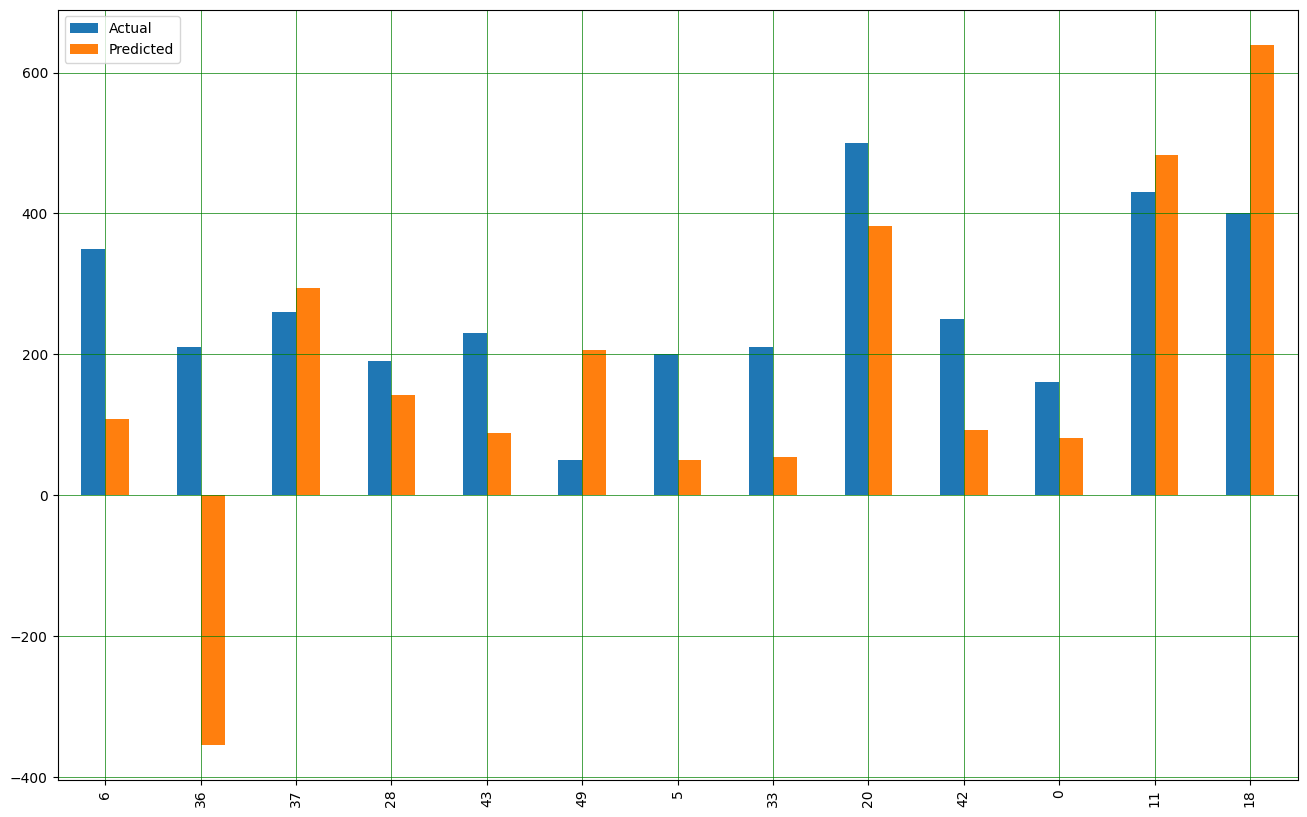

In [22]:
res1 = res.head(25)
res1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [23]:
lin_regressor=skl.LinearRegression()
K = 5
kfold = skm.KFold(K,
                  random_state=100,
                  shuffle=True)

mse=skm.cross_val_score(lin_regressor,X_train,y_train,scoring='neg_mean_squared_error',cv=kfold)

mean_mse=np.mean(mse)
print("MSE")
print(mean_mse)
print("RMSE: ")
RMSE=np.sqrt(np.mean(np.absolute(mse)))
print(RMSE)




MSE
-93487.28491086632
RMSE: 
305.756904927536


In general, the lower the MAE, the more closely a model is able to predict the actual observations.
The lower the RMSE, the more closely a model is able to predict the actual observations.
In practice we typically fit several different models and compare the RMSE or MAE of each model 
to decide which model produces the lowest test error rates and is therefore the best model to use.

In [24]:
ridgeReg = skl.Ridge()
#1e-15= 0.000000000000001
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100,120,150,200,250,300,350,500,1000,2000,5000,6000,10000]}
ridgeReg.fit(X_train,y_train)
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

ridge_regressor=skm.GridSearchCV(ridgeReg,parameters,scoring='neg_mean_squared_error',cv=kfold)


ridgereg=ridge_regressor.fit(X_train,y_train)
ridgereg

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100, 120, 150,
                                   200, 250, 300, 350, 500, 1000, 2000, 5000,
                                   6000, 10000]},
             scoring='neg_mean_squared_error')

In [25]:
# Let's check out the best parameter and the score

print(ridge_regressor.best_params_)
mse= ridge_regressor.best_score_
print(mse)

print("RMSE: ")
print(np.sqrt(np.mean(np.absolute(mse))))



{'alpha': 10000}
-30165.447112456935
RMSE: 
173.68202875501234


In [26]:
y_predRidge= ridge_regressor.predict(X_test)
mean_squared_error(y_test, y_predRidge)

14431.9391782039

In [27]:
resRidge = pd.DataFrame({'Actual': y_test, 'Predicted': y_predRidge})
resRidge

,Actual,Predicted
6,350,278.398463
36,210,197.539262
37,260,215.480020
28,190,193.790913
43,230,243.599738
49,50,229.865955
5,200,280.073858
33,210,194.978928
20,500,257.108757
42,250,284.532429


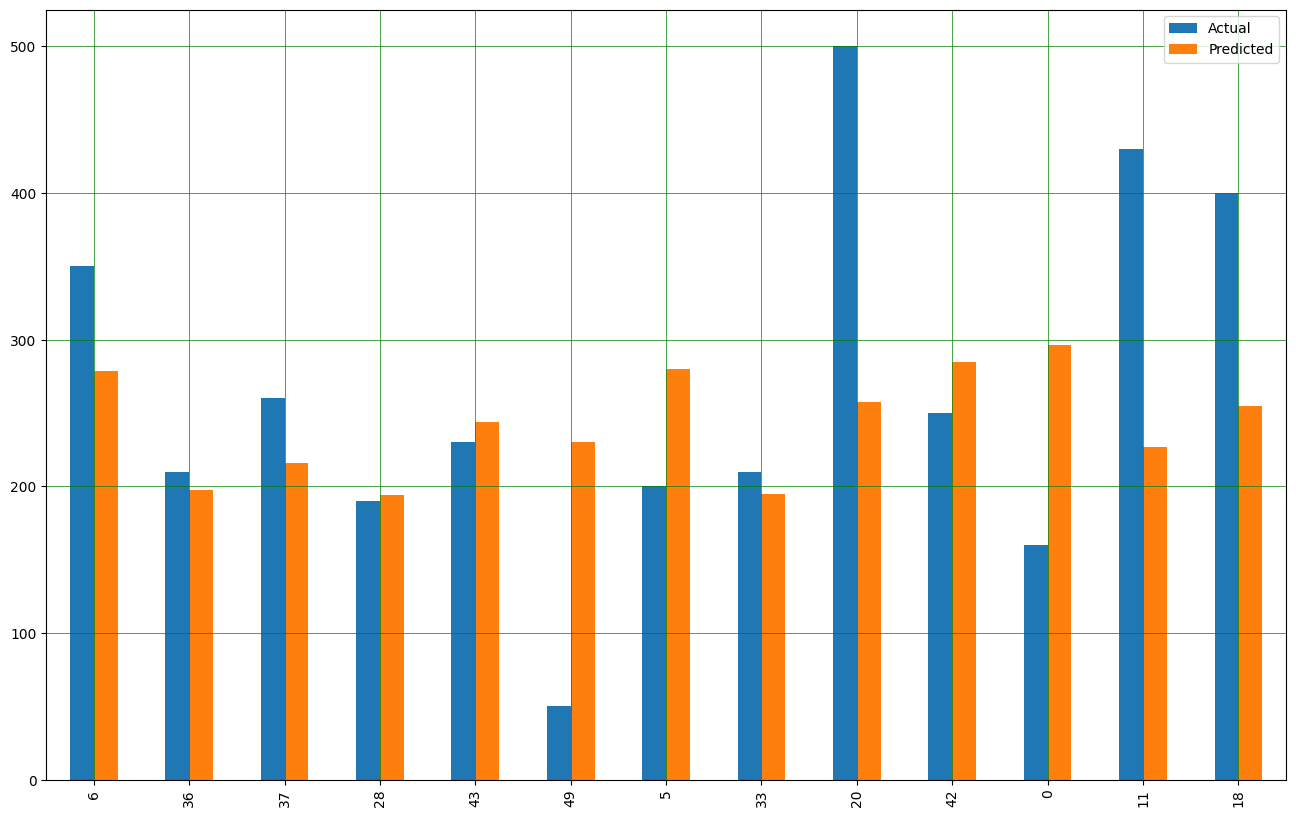

In [28]:
resRidge = resRidge.head(25)
resRidge.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [29]:
lasso=skl.Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100,120,150,200,250,300,350,500,1000,2000,5000,5100,5500,6000,10000]}
K = 5
kfold = skm.KFold(K,
                  random_state=100,
                  shuffle=True)
lasso_regressor=skm.GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=kfold)

lassoreg= lasso_regressor.fit(X_train,y_train)
lassoreg

d:\Facultad\Inteligencia artificial 2\Ch4\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.254e+04, tolerance: 1.095e+02
  model = cd_fast.enet_coordinate_descent(
d:\Facultad\Inteligencia artificial 2\Ch4\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.553e+04, tolerance: 1.072e+02
  model = cd_fast.enet_coordinate_descent(
d:\Facultad\Inteligencia artificial 2\Ch4\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100, 120, 150,
                                   200, 250, 300, 350, 500, 1000, 2000, 5000,
                                   5100, 5500, 6000, 10000]},
             scoring='neg_mean_squared_error')

In [30]:
# Let's check out the best parameter and best score

print(lasso_regressor.best_params_)
mse= lasso_regressor.best_score_
print(mse)

print("RMSE: ")
print(np.sqrt(np.mean(np.absolute(mse))))


{'alpha': 5000}
-33289.7662078223
RMSE: 
182.45483333642412


In [31]:
y_predLasso= lassoreg.predict(X_test)
mean_squared_error(y_test, y_predLasso)

15744.322023206068

In [32]:
resLasso = pd.DataFrame({'Actual': y_test, 'Predicted': y_predLasso})
resLasso

,Actual,Predicted
6,350,245.660462
36,210,204.407453
37,260,207.845204
28,190,204.407453
43,230,245.660462
49,50,230.381570
5,200,245.660462
33,210,204.407453
20,500,222.742124
42,250,268.578800


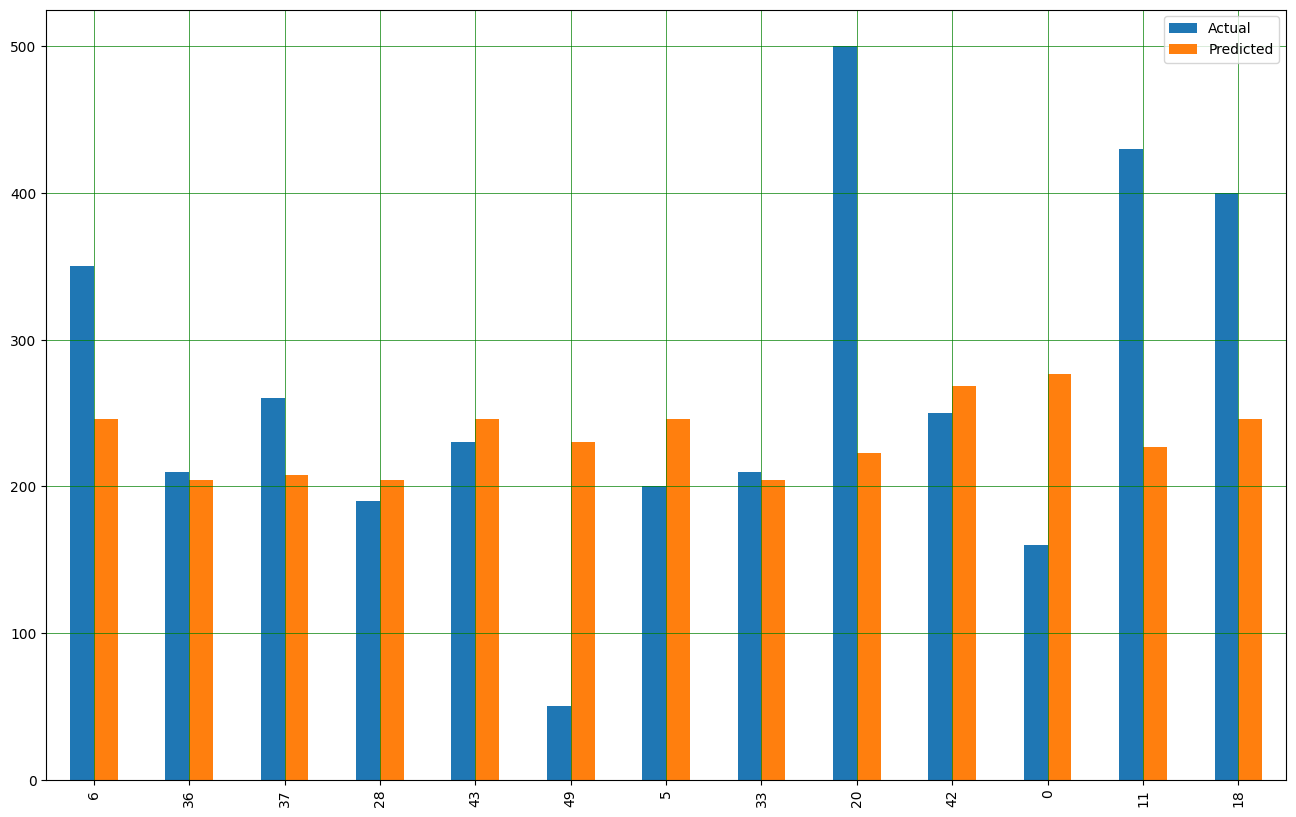

In [33]:
resLasso = resLasso.head(25)
resLasso.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

**Seleccion de variables/parametros utilizando** sklearn_selected(OLS,
                                                            strategy,
                                                            scoring=neg_Cp)

In [34]:

X=df_Con_Cp.drop(['Waste after oven'],axis=1)
X.shape

y=df_Con_Cp['Waste after oven']
y.shape


(50,)

In [35]:
X_train,X_test,y_train,y_test = skm.train_test_split(X,y,
                                                 test_size = 0.25,
                                                random_state = 100)

#random_state” is a parameter in train_test_split that controls the random number generator used to shuffle the data before splitting it. 
# In other words, it ensures that the same randomization is used each time you run the code, resulting in the same splits of the data.

X_train.shape
X_train.dtypes

Color after oven (numeric)      int64
Days since harvest              int64
Polar fraction of fat         float64
Sugar content                 float64
Time in tank (seconds)          int64
dtype: object

In [36]:
y_test

6     350
36    210
37    260
28    190
43    230
49     50
5     200
33    210
20    500
42    250
0     160
11    430
18    400
Name: Waste after oven, dtype: int64

In [37]:
regressor = skl.LinearRegression()
regressor.fit(X_train, y_train) #training the algorithm

y_pred = regressor.predict(X_test)

res2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(res2)


    Actual   Predicted
6      350  128.950395
36     210 -115.229515
37     260  294.635368
28     190   96.589005
43     230  289.128609
49      50  136.980547
5      200   63.474261
33     210  138.929117
20     500  375.751253
42     250  215.629473
0      160   55.651533
11     430  445.123287
18     400  592.470372


In [38]:
print("Error cuadrático medio")
mse=mean_squared_error(y_test,y_pred)
print(mse)
print("RMSE")
RMSE=np.sqrt(np.mean(np.absolute(mse)))
print(RMSE)

Error cuadrático medio
20315.06066728593
RMSE
142.53091126940123


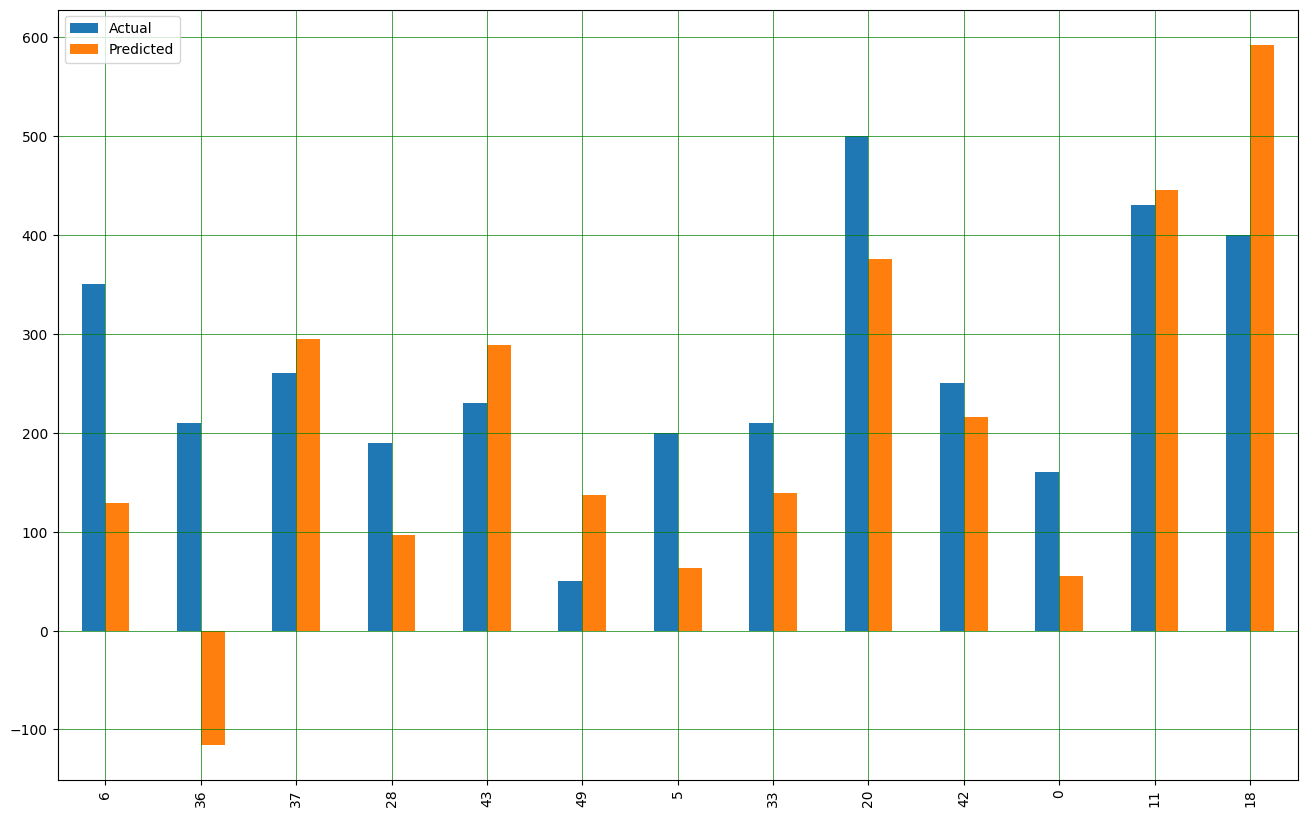

In [39]:
res2 = res2.head(25)
res2.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [40]:
lin_regressor=skl.LinearRegression()
K = 5
kfold = skm.KFold(K,
                  random_state=100,
                  shuffle=True)

mse=skm.cross_val_score(lin_regressor,X_train,y_train,scoring='neg_mean_squared_error',cv=kfold)

mean_mse=np.mean(mse)
print("MSE")
print(mean_mse)
print("RMSE: ")
RMSE=np.sqrt(np.mean(np.absolute(mse)))
print(RMSE)



MSE
-46809.10382003088
RMSE: 
216.35411671616254


In [41]:
ridgeReg = skl.Ridge()
#1e-15= 0.000000000000001
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100,120,150,200,250,300,350,500,1000,2000,5000,6000,10000]}
ridgeReg.fit(X_train,y_train)
K = 5
kfold = skm.KFold(K,
                  random_state=100,
                  shuffle=True)

ridge_regressor=skm.GridSearchCV(ridgeReg,parameters,scoring='neg_mean_squared_error',cv=kfold)


ridgereg=ridge_regressor.fit(X_train,y_train)
ridgereg

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100, 120, 150,
                                   200, 250, 300, 350, 500, 1000, 2000, 5000,
                                   6000, 10000]},
             scoring='neg_mean_squared_error')

In [42]:
# Let's check out the best parameter and the score

print(ridge_regressor.best_params_)
mse= ridge_regressor.best_score_
print(mse)

print("RMSE: ")
print(np.sqrt(np.mean(np.absolute(mse))))



{'alpha': 10000}
-35951.23895442668
RMSE: 
189.60811943170228


In [43]:
y_predRidge= ridge_regressor.predict(X_test)
mean_squared_error(y_test, y_predRidge)

12898.72713361633

In [44]:
resRidge = pd.DataFrame({'Actual': y_test, 'Predicted': y_predRidge})
resRidge

,Actual,Predicted
6,350,258.802917
36,210,224.802486
37,260,251.503099
28,190,218.603206
43,230,221.730751
49,50,220.996272
5,200,258.562710
33,210,205.044445
20,500,276.391357
42,250,233.099661


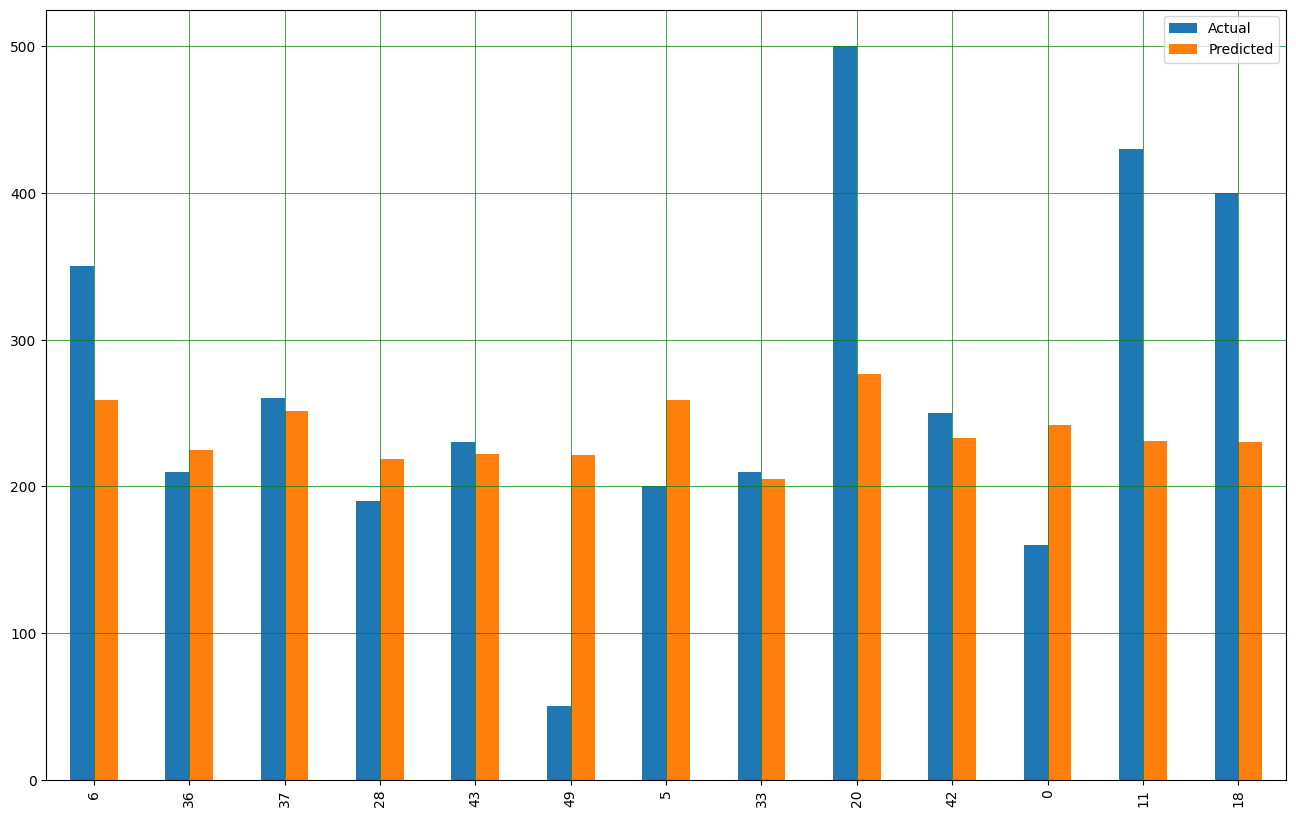

In [45]:
resRidge = resRidge.head(25)
resRidge.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

**Lasso**

In [46]:
lasso=skl.Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100,120,150,200,250,300,350,500,1000,2000,5000,5100,5500,6000,10000]}
K = 5
kfold = skm.KFold(K,
                  random_state=100,
                  shuffle=True)
lasso_regressor=skm.GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=kfold)

lassoreg= lasso_regressor.fit(X_train,y_train)
lassoreg

d:\Facultad\Inteligencia artificial 2\Ch4\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.119e+05, tolerance: 1.095e+02
  model = cd_fast.enet_coordinate_descent(
d:\Facultad\Inteligencia artificial 2\Ch4\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e+05, tolerance: 1.072e+02
  model = cd_fast.enet_coordinate_descent(
d:\Facultad\Inteligencia artificial 2\Ch4\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100, 120, 150,
                                   200, 250, 300, 350, 500, 1000, 2000, 5000,
                                   5100, 5500, 6000, 10000]},
             scoring='neg_mean_squared_error')

In [47]:
# Let's check out the best parameter and best score

print(lasso_regressor.best_params_)
mse= lasso_regressor.best_score_
print(mse)

print("RMSE: ")
print(np.sqrt(np.mean(np.absolute(mse))))

{'alpha': 5000}
-34190.15558730159
RMSE: 
184.90580192979772


In [48]:
y_predLasso= lassoreg.predict(X_test)
mean_squared_error(y_test, y_predLasso)

15043.19003202787

In [49]:
resLasso = pd.DataFrame({'Actual': y_test, 'Predicted': y_predLasso})
resLasso


,Actual,Predicted
6,350,232.945946
36,210,232.945946
37,260,232.945946
28,190,232.945946
43,230,232.945946
49,50,232.945946
5,200,232.945946
33,210,232.945946
20,500,232.945946
42,250,232.945946


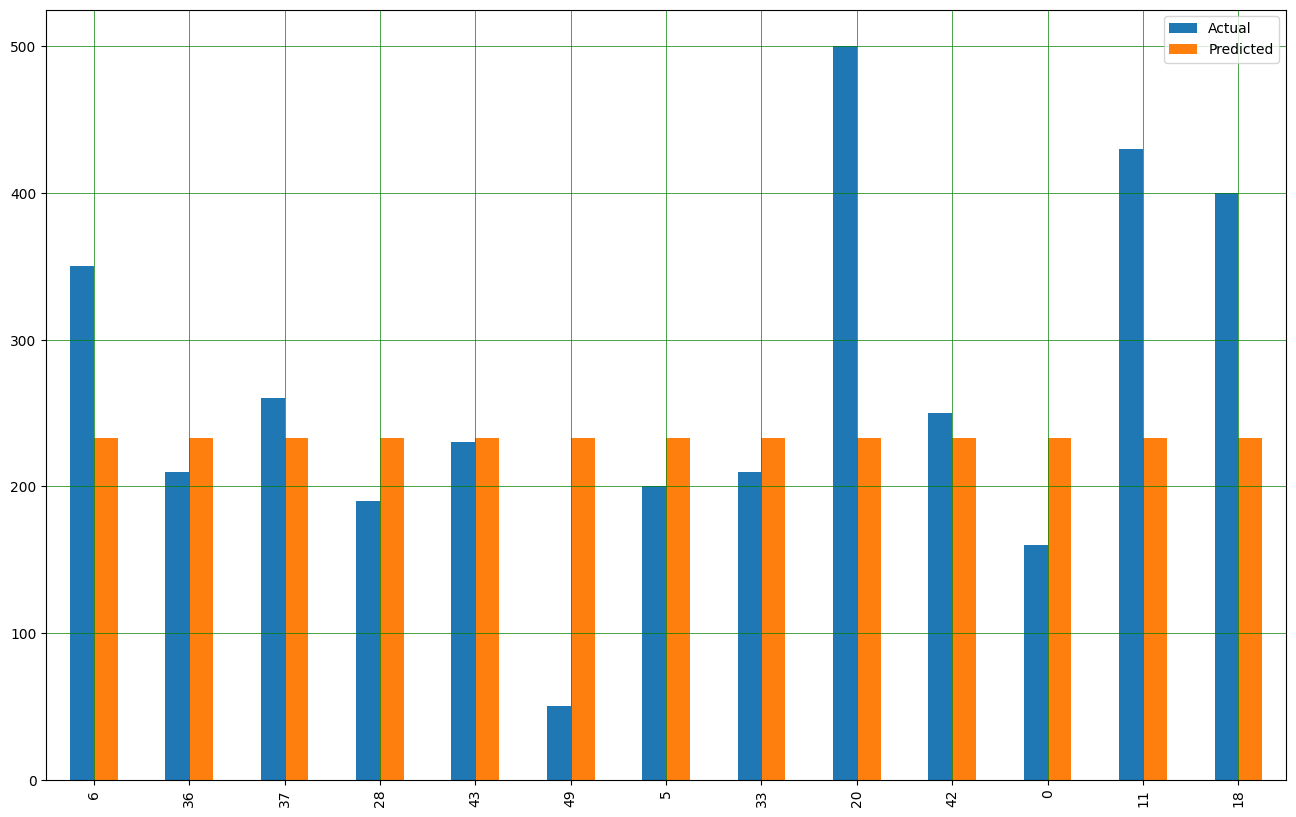

In [50]:
resLasso = resLasso.head(25)
resLasso.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()